In [137]:

% matplotlib notebook
import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr
from scipy.ndimage import gaussian_filter
from scipy.signal import wiener
import math
import scipy

import json
from utils import *
from indicator_simulation import *


<IPython.core.display.Javascript object>


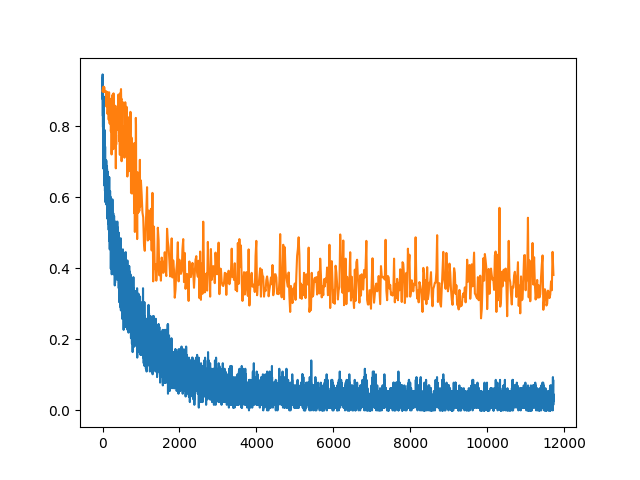

In [212]:
# read train data
event_file = 'data/cifar10/cifar_subset_train_summary_1/train'
relative_time = []
train_epochs = []
train_err = []
summary = tf.train.summary_iterator(event_file)
for i, e in enumerate(summary):
    for v in e.summary.value:
        if v.tag == 'train_accuracy_1':
            train_epochs.append(e.step)
            train_err.append(1-v.simple_value)

plt.figure()
plt.plot(train_epochs, train_err)

# read eval data
event_file = 'data/cifar10/cifar_subset_train_summary_1/eval'
# event_file = 'data/bs_32_eval'
# event_file = 'data/eval_wo_lr_decay'
relative_time = []
eval_epochs = []
eval_err = []
summary = tf.train.summary_iterator(event_file)
for i, e in enumerate(summary):
    for v in e.summary.value:
        if v.tag == 'accuracy':
            eval_epochs.append(e.step)
            eval_err.append(1-v.simple_value)

# plt.figure()
plt.plot(eval_epochs, eval_err)

dict_ = {'train_epochs': train_epochs, 'train_err': train_err, 'eval_epochs': eval_epochs, 'eval_err':eval_err}
# store as jsons file
with open('jsons/cifar_subset_train_summary_1.json', 'w') as f:
    json.dump(dict_,f)

<IPython.core.display.Javascript object>


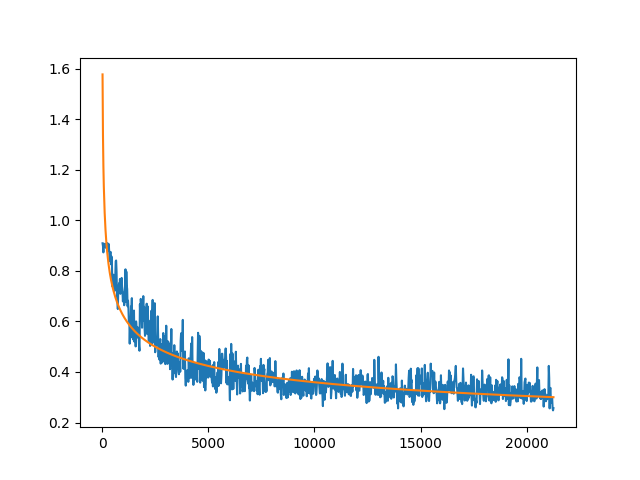

<IPython.core.display.Javascript object>


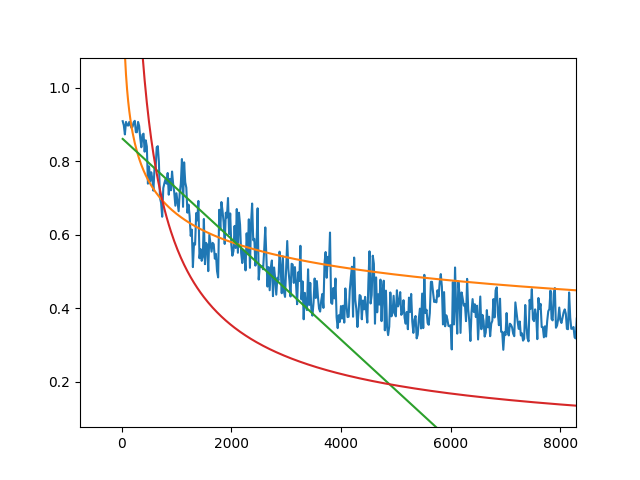

0.0013283111873418937 0.016028838370967288
314
16918.2


In [207]:
err = np.array(eval_err)
epochs = np.array(eval_epochs)
bnds = ((0, None), (None, 0), (None,None))
inits = (1,0,0)

a, b = power_regression(epochs, err, weights = np.ones(len(epochs)))
d = 0
# a = rst.x[0]
# b = rst.x[1]
# c = rst.x[2]
plt.figure()
plt.plot(epochs, err)
plt.plot(epochs, a*np.power(epochs, b))
# plt.plot(train_epochs, np.exp(-a*(train_epochs+b))+c)

var = np.var(a*np.power(epochs[len(epochs)-300:], b) - err[len(epochs)-300:])


# min_delta = 5e-4
# patience = 15
# pred, stopping_epochs, sample, smoothed_sample = early_stopping_prediction_adding_noise(
#                                                                     a,b,d,0,var2,
#                                                                     min_delta,patience,
#                                                                      20,
#                                                                      55,
#                                                                      num_samples=100,
#                                                                      upper_limit=2e5,
#                                                                      lower_limit=epochs[-1],
#                                                                                      )
# print(pred)

end = 150
a0, b0 = power_regression(epochs[:end], err[:end], weights = np.ones(end))
d = 0
# a = rst.x[0]
# b = rst.x[1]
# c = rst.x[2]
plt.figure()
plt.plot(epochs, err)
plt.plot(epochs, a0*np.power(epochs, b0))
# plt.plot(train_epochs, np.exp(-a*(train_epochs+b))+c)
var2 = np.var(a0*np.power(epochs[:25], b0) - err[:25])
print(var, var2)
min_delta = 5e-4
patience = 10
# pred, stopping_epochs, sample, smoothed_sample = early_stopping_prediction_adding_noise(
#                                                                     a0,b0,d,0,var,
#                                                                     min_delta,patience,
#                                                                      20,
#                                                                      55,
#                                                                      num_samples=100,
#                                                                      upper_limit=2e5,
#                                                                      lower_limit=500,
#                                                                                      )


A = np.vstack([epochs[:end], np.ones(end)]).T
a1, b1 = np.linalg.lstsq(A, err[:end], rcond=-1)[0]
linear_end = math.floor(-b1/a1/20)
print(linear_end)
plt.plot(epochs[:linear_end], a1*epochs[:linear_end]+b1)

a2, b2 = power_regression(epochs[:linear_end], a1*epochs[:linear_end]+b1, weights = np.ones(linear_end))
a2, b2 = power_regression(np.arange(1,linear_end+1)*20, a1*np.arange(1,linear_end+1)*20+b1, weights = np.ones(linear_end))
plt.plot(epochs, a2*np.power(epochs, b2))
pred, stopping_epochs, sample, smoothed_sample = early_stopping_prediction_adding_noise(
                                                                    a2,b2,d,0,var2,
                                                                    min_delta,patience,
                                                                     20,
                                                                     55,
                                                                     num_samples=100,
                                                                     upper_limit=2e5,
                                                                     lower_limit=500,
                                                                                     )
print(pred)

<IPython.core.display.Javascript object>


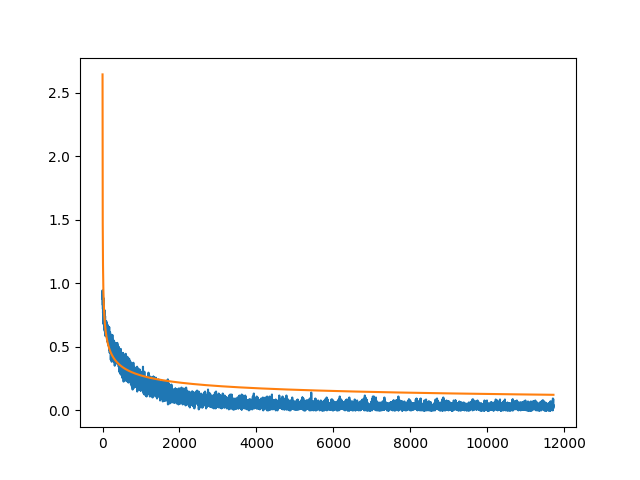

In [113]:
train_err = np.array(train_err)
train_epochs = np.array(train_epochs)
end = 1000
bnds = ((0, None), (None, 0), (None,None))
inits = (1,0,0)

# fun = lambda x: np.sum(np.power(train_err[:end]-(np.exp(x[1]*np.log(train_epochs[:end])+np.log(x[0]))),2))
# fun = lambda x: np.sum(np.power(train_err[:end]-(np.exp(-x[0]*(train_epochs[:end]+x[1]))+x[2]),2))
# rst = scipy.optimize.minimize(fun, inits, method='TNC', bounds=bnds)
a, b = power_regression(train_epochs[:end], train_err[:end], weights = np.ones(end))
# a = rst.x[0]
# b = rst.x[1]
# c = rst.x[2]
plt.figure()
plt.plot(train_epochs, train_err)
plt.plot(train_epochs, a*np.power(train_epochs, b))
# plt.plot(train_epochs, np.exp(-a*(train_epochs+b))+c)

<IPython.core.display.Javascript object>


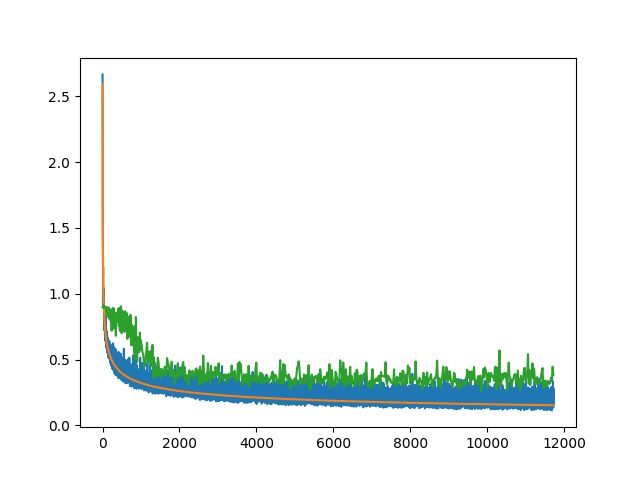

In [126]:
plt.figure()
var = 0.01
num_points = len(train_epochs)
noise = np.random.rayleigh(np.sqrt((4-np.pi)/2*var), num_points) - var*np.sqrt(np.pi/2)
values = a*np.power(train_epochs, b)+noise
plt.plot(train_epochs, values)
end = 100
a1, b1 = power_regression(train_epochs[:end], values[:end], weights = np.ones(end))
plt.plot(train_epochs, a1*np.power(train_epochs, b1))
